## The approximation for the full foil when p/c=0

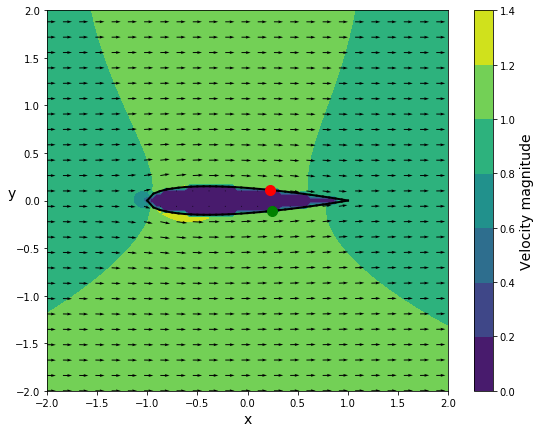

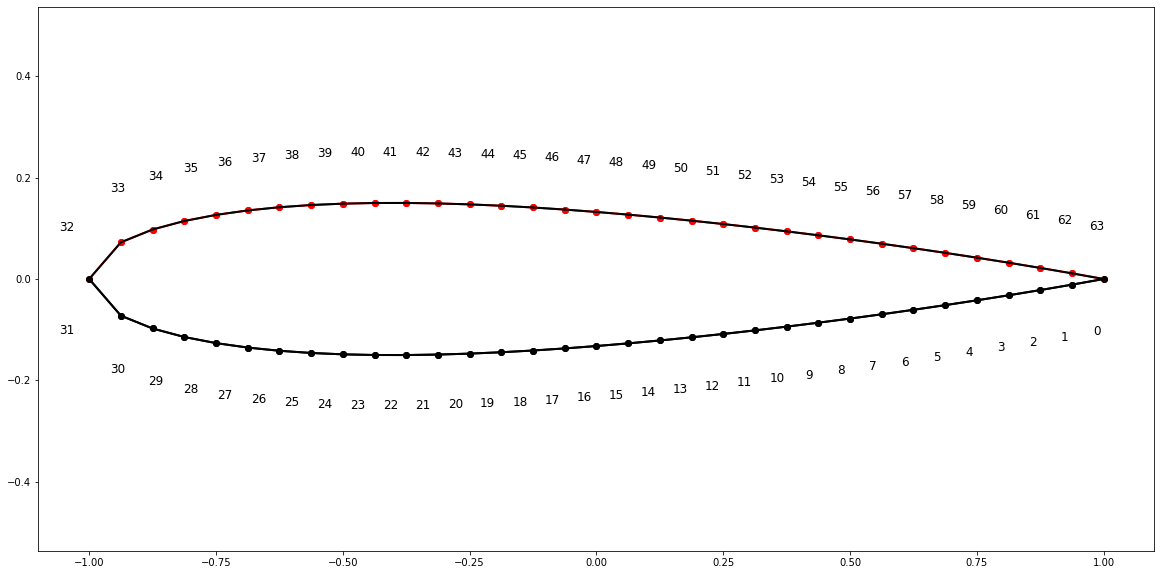

In [156]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Actual import code
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
from vortexpanel import VortexPanel as vp
from vortexpanel import BoundaryLayer as bl

def naca_offset(x,t=0.15): 
    return 5*t*(0.2969*np.sqrt(x)-0.1260*x-0.3516*x**2+0.2843*x**3-0.1036*x**4)
 

def make_trunc(N, p_c, t_c=0.15):
    """makes a truncated naca foil, thickness/chord = 0.15,
    with N panels along the sides and an extra panel across the end,
    truncated by a ratio of p/c
    returns the PanelArray and kutta condition tuple
   
    # example initalisation
    foil, kutta_con = make_trunc(64, 0.15)
    foil.solve_gamma_O2(alpha=0.3, kutta=kutta_con)
    """
    p = 1 - p_c
    if p == 1:
        n = np.linspace(0, 1, int((N+2)/2))
        x = 2*np.delete(np.append(np.flip(n), n), len(n)) - 1
        y = 2*np.delete(np.append(-1*np.flip(naca_offset(n, t=t_c)), naca_offset(n, t=t_c)), len(n))
        kutta_con = [(0, -1)]
    else:
        n = np.linspace(0, p, int((N+1)/2))
        x = 2*np.append(np.delete(np.append(np.flip(n), n), len(n)), [p, p]) - 1
        y = 2*np.append(np.delete(np.append(-1*np.flip(naca_offset(n, t=t_c)), naca_offset(n, t=t_c)), len(n)), 0)
        y = np.append(y, y[0])
        kutta_con = [(0, -3)]
    return vp.panelize(x, y), kutta_con
 

# example initalisation
foil, kutta_con = make_trunc(64, 0)
alpha=0
foil.solve_gamma_O2(alpha,kutta_con)
top,bot = foil.split()

foil.plot_flow()
_,_,itop=top.thwaites()
_,_,ibot=bot.thwaites()

xtop=bl.sep(top.get_array('xc'),itop)
ytop=bl.sep(top.get_array('yc'),itop)
plt.scatter(xtop,ytop,s=100,c='r',zorder=10)

xbot=bl.sep(bot.get_array('xc'),ibot)
ybot=bl.sep(bot.get_array('yc'),ibot)
plt.scatter(xbot,ybot,s=100,c='g',zorder=10)

plt.show()
fig= plt.figure(figsize=(20,10))
top.plot('ro-')
bot.plot('ko-')
plt.axis('equal')
foil.plot(nlabel=1)

## The Jukowski foil 

t/c=0.150


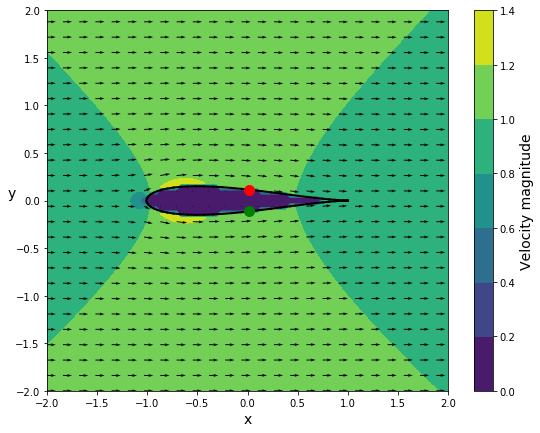

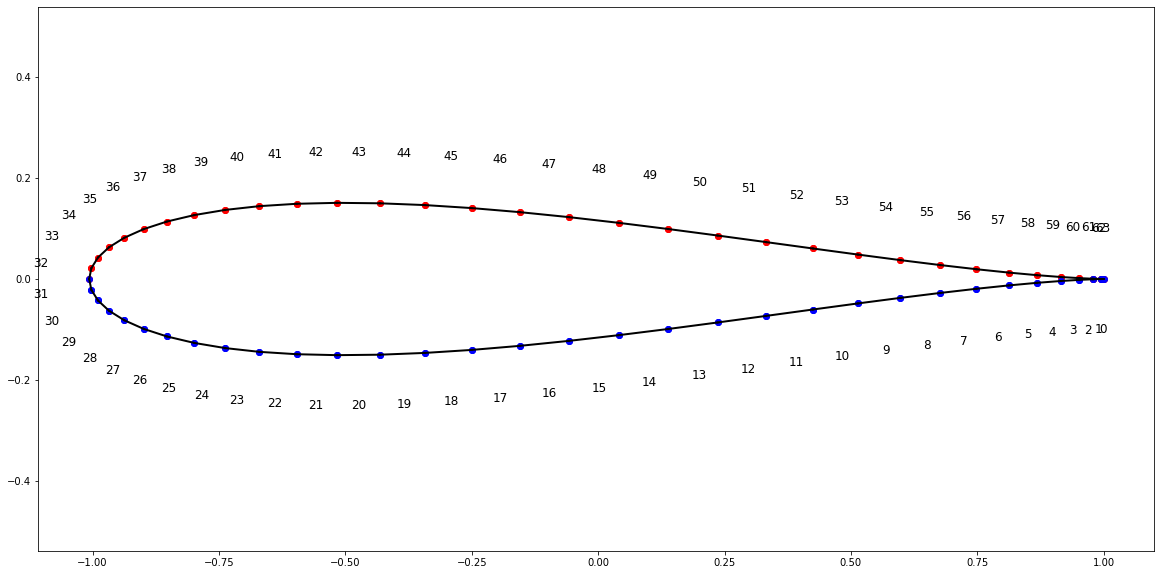

In [157]:
jfoil=vp.make_jfoil(64,xcen=-0.0614)


alpha=0

jfoil.solve_gamma_O2(alpha,kutta=[(0,-1)])
def t_c(panels):
    xc,yc=panels.get_array('xc','yc')
    c=max(xc)-min(xc)
    t=max(yc)-min(yc)
    return t/c

print('t/c={:.3f}'.format(t_c(jfoil)))

jfoil.plot_flow()

top,bot=jfoil.split()
_,_,itop=top.thwaites()
_,_,ibot=bot.thwaites()

xtop=bl.sep(top.get_array('xc'),itop)
ytop=bl.sep(top.get_array('yc'),itop)
plt.scatter(xtop,ytop,s=100,c='r',zorder=10)
xbot=bl.sep(bot.get_array('xc'),ibot)
ybot=bl.sep(bot.get_array('yc'),ibot)
plt.scatter(xbot,ybot,s=100,c='g',zorder=10)
#plt.show()
fig= plt.figure(figsize=(20,10))
top.plot('ro')
bot.plot('bo')
plt.axis('equal')
jfoil.plot(nlabel=1)

### Separation Point

In [158]:
# for the full foil
@np.vectorize
def foil_sep(foil,N=64):
    top,_=foil.split()
    _,_,iSep=top.thwaites()
    x=top.get_array('xc')
    x_c=(x-min(x))/(max(x)-min(x))
    return bl.sep(x_c,iSep)


print(foil_sep(foil))
print(foil_sep(jfoil))

0.615599660705838
0.5109616534881816


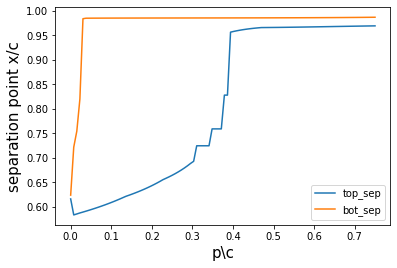

In [159]:
# for the truncated foil
@np.vectorize
def trunc_sep(t):
    nfoil, kutta_con = make_trunc(64,t/100)
    alpha=0
    nfoil.solve_gamma_O2(alpha,kutta_con)
    top,bot=nfoil.split()
    _,_,iSep_top=top.thwaites()
    _,_,iSep_bot=bot.thwaites()
    x=top.get_array('xc')
    y=bot.get_array('xc')
    x_c=(x-min(x))/(max(x)-min(x))
    y_c=(y-min(y))/(max(y)-min(y))
    top_sep=bl.sep(x_c,iSep_top)
    bot_sep=bl.sep(y_c,iSep_bot)
    return top_sep,bot_sep
t=np.linspace(0,75,100)
top,bot=trunc_sep(t)
plt.plot(t/100,top,label='top_sep')
plt.plot(t/100,bot,label='bot_sep')
plt.legend()
plt.xlabel(r'p\c', fontsize=15)
plt.ylabel(r'separation point x/c', fontsize=15);

### Drag Coefficient

In [144]:
def C_gamma(panels):
    top,bot=panels.split()
    _,_,iSep=top.thwaites()
    gamma_top=bl.sep(top.get_array('gamma'),iSep)
    w_top=bl.sep(top.get_array('yc'),iSep)
    y=panels.get_array('yc')
    t=max(y)-min(y)
    return 2*w_top/t*gamma_top**2

0.7986247385685102 0.9203356921148662


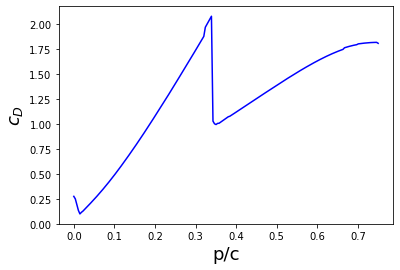

In [145]:
# drag coefficient for the full foil
print(C_gamma(foil),C_gamma(jfoil))
# drag coefficient for the foil with a range of  p/c
@np.vectorize
def drag(t):
    trunc, kutta_con = make_trunc(64,t/100)
    alpha=0
    trunc.solve_gamma_O2(alpha,kutta_con)
    C_D=0.343*C_gamma(trunc)
    return C_D
t=np.linspace(0,75,200)
C_D=drag(t)
plt.plot(t/100,C_D,'b')
plt.xlabel(r'p/c', fontsize=18)
plt.ylabel(r'$c_D$', fontsize=18)


### Lift Coefficient

In [150]:
# lift force caused by the pressure
def C_L(panels,alpha):
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy')
    c = max(xc)-min(xc)
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)
    return -sum((1-gamma**2)*2*S*perp)/c

print("foil C_L = {:.3f}".format(C_L(foil,alpha=0)))
print("jfoil C_L = {:.3f}".format(C_L(jfoil,alpha=0)))

foil C_L = -0.098
jfoil C_L = -0.004


In [155]:
# total lift based on the circulation-based formula
def analytic_C_L(alpha):
    t_c=0.15 
    return 2*np.pi*(1+4/(3*np.sqrt(3))*t_c)*np.sin(alpha)

@np.vectorize
def numeric_C_L(alpha,panels):
    gamma,S,xc=panels.get_array('gamma','S','xc')
    c=max(xc)-min(xc)
    C_L = -sum(gamma*2*S)/(0.5*c)
    return C_L

print(analytic_C_L(alpha))
print("foil C_L = {:.3f}".format((numeric_C_L(alpha,foil))))
print("jfoil C_L = {:.3f}".format(numeric_C_L(alpha,jfoil)))

0.0
foil C_L = -0.107
jfoil C_L = -0.004


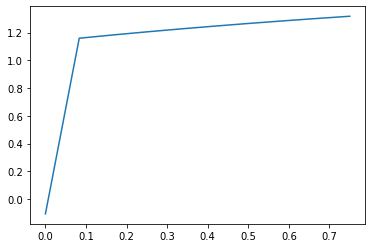

In [148]:
@np.vectorize
def numtrunc_C_L(t):
    trunc, kutta_con = make_trunc(64,t/100)
    alpha=0
    trunc.solve_gamma_O2(alpha,kutta_con)
    gamma,S,xc=trunc.get_array('gamma','S','xc')
    c=max(xc)-min(xc)
    C_L = -sum(gamma*2*S)/(0.5*c)
    return C_L
t=np.linspace(0,0.75,10)
plt.plot(t,numtrunc_C_L(t))

### Added mass for the full foil

In [149]:
y,x=foil.get_array('yc','xc')
c=max(x)-min(x)
t=max(y)-min(y)

area=0
for i in range(1,64):
    area=area+c/32*abs(y[i])

C_yy=np.pi*c**2/(4*area)
C_xx=np.pi*t**2/(4*area)
print ('C_yy=',C_yy,'\nC_xx=',C_xx)

C_yy= 7.494632776847816 
C_xx= 0.17938123662908795


In [138]:
help(vp)

Help on module vortexpanel.VortexPanel in vortexpanel:

NAME
    vortexpanel.VortexPanel - Solve potential flow problems using vortex panels

DESCRIPTION
    This module holds routines to determine the potential flow and
    separation point around bodies of any shape or number using
    vortex panels and laminar boundary layer theory.
    
    Classes:
        Panel, PanelArray
    
    Methods:
        panelize, concatenate
        make_ellipse, make_circle, make_jfoil, make_spline
    
    Imports:
        numpy, pyplot from matplotlib, march & sep from BoundaryLayer

CLASSES
    builtins.object
        Panel
        PanelArray
    
    class Panel(builtins.object)
     |  Panel(x0, y0, x1, y1, gamma=0)
     |  
     |  Vortex panel class
     |  
     |  Attributes:
     |  xc,yc -- the x and y location of the panel center
     |  S     -- the half-width of the panel
     |  sx,sy -- the x and y component of the tangent unit vector
     |  gamma -- the panel vortex strength
     | 